In [1]:
import glob
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', 500)
tqdm.pandas()

## Import the csv files

In [5]:
# Result of the PSQL merge which cause memory error with Python
df_merge = pd.read_csv('FACIT/merge.csv')
df_merge.drop_duplicates(inplace=True)
df_merge['finearts_date'] = pd.to_datetime(
    df_merge['finearts_date'], 
    format='%Y-01-01', 
    errors='coerce')
df_merge.shape

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (2,5,8,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(15923, 13)

In [6]:
df_merge.dtypes

faartist_surname           object
fap_definition             object
finearts_date              object
finearts_appraisal        float64
finearts_building_id      float64
finearts_deaccessioned     object
dim_width_inches          float64
dim_height_inches         float64
building_city              object
building_id               float64
building_name              object
building_state             object
building_zip              float64
dtype: object

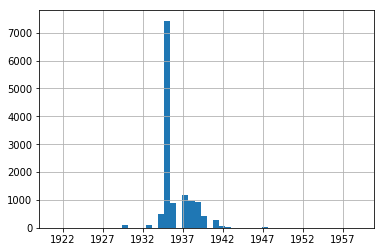

In [36]:
df_merge[
    (df_merge['finearts_date'].dt.year > 1920)
    & (df_merge['finearts_date'].dt.year < 1960)]['finearts_date'].hist(bins=50)

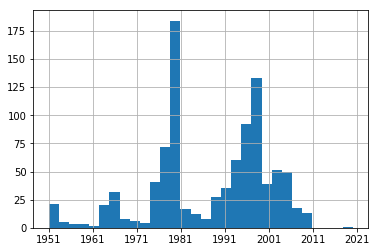

In [37]:
df_merge[df_merge['finearts_date'].dt.year > 1950]['finearts_date'].hist(bins=30)

In [12]:
df_merge['finearts_appraisal'].sum()

46302861.0

In [40]:
df_merge['faartist_surname'].value_counts()

Murphy                         263
Polos                          158
Unknown                        148
Gallagher                      138
Dean                           133
Constant                       129
Surendorf                      127
Flint                          117
Dorgeloh                       110
Hagedorn                       105
Becker                         104
Pytlak                         102
Dwight                         102
Mesibov                         97
Abelman                         96
Olds                            95
Thrash                          94
Pommer                          94
Wulf                            88
Kahn                            85
Chaney                          81
Chun                            77
Vogel                           76
Oldfield                        75
Nooney                          75
Webb                            73
Lewis                           72
Kubinyi                         71
Gottlieb            

In [41]:
df_merge['building_city'].value_counts()

Washington         9861
San Francisco        50
Philadelphia         38
New York             35
Auburn               32
Detroit              30
Cleveland            30
Atlanta              29
Cincinnati           25
Chicago              24
Indianapolis         22
Oklahoma City        17
Sacramento           17
Albany               16
Denver               15
Los Angeles          13
Portland             13
Kansas City          12
New Orleans          11
Miami                11
Little Rock          10
Erie                 10
Honolulu              9
Seattle               9
Albuquerque           9
Ocala                 9
Richmond              8
Boston                8
Eugene                8
Jamaica, Queens       7
                   ... 
Alexandria            1
Roosville             1
Bismarck              1
Hawthorne             1
San Luis              1
Provo                 1
Santa Rosa            1
Allentown             1
Fargo                 1
Iowa City             1
Menlo Park      

In [39]:
df_merge.loc[df_merge['finearts_appraisal'] > 0].sort_values('finearts_appraisal', ascending=False)

,faartist_surname,fap_definition,finearts_date,finearts_appraisal,finearts_building_id,finearts_deaccessioned,dim_width_inches,dim_height_inches,building_city,building_id,building_name,building_state,building_zip
16334099,Puryear,Art-in-Architecture,1997-01-01,1000000.0,109.0,0,NaN,NaN,Washington,109.0,Ronald Reagan Building,DC,20002.0
15490302,Stella,Art-in-Architecture,2005-01-01,875000.0,317.0,0,192.0,198.0,Central Islip,317.0,USDC Long Island Federal Courthouse,NY,11722.0
3405,French,New Deal Fine Art Projects,1939-01-01,825000.0,430.0,0,83.0,13.0,Richmond,430.0,Court House Annex,VA,23200.0
3414,Cadmus,New Deal Fine Art Projects,1939-01-01,825000.0,430.0,0,83.0,36.0,Richmond,430.0,Court House Annex,VA,23200.0
15703188,Kelly,Art-in-Architecture,1998-01-01,800000.0,192.0,0,NaN,NaN,Boston,192.0,U.S. Courthouse,MA,2205.0
15490260,Dine,Art-in-Architecture,2003-01-01,708000.0,334.0,0,NaN,NaN,Cleveland,334.0,Carl B. Stokes U.S. Courthouse,OH,44114.0
16334097,Sonnier,Art-in-Architecture,1997-01-01,700000.0,109.0,0,30.0,49.0,Washington,109.0,Ronald Reagan Building,DC,20002.0
8639256,Calder,Art-in-Architecture,1973-01-01,700000.0,480.0,0,68.0,92.0,Chicago,480.0,USPO Loop Station,IL,60604.0
9271919,Calder,Fine Arts,1965-01-01,700000.0,308.0,0,11.0,11.0,New York,308.0,Jacob K. Javitz Federal Building/Court of Int...,NY,10278.0
14384,Berninghaus,New Deal Fine Art Projects,1938-01-01,600000.0,20.0,1,46.0,229.0,Phoenix,20.0,Federal Building & U.S. Post Office,AZ,85004.0


In [32]:
df_merge.loc[df_merge['finearts_date'].dt.year > 1960].sort_values('finearts_date', ascending=False)

,faartist_surname,fap_definition,finearts_date,finearts_appraisal,finearts_building_id,finearts_deaccessioned,dim_width_inches,dim_height_inches,building_city,building_id,building_name,building_state,building_zip
12542918,Kaprov,Art-in-Architecture,2020-01-01,0.0,476.0,0,14.0,27.0,NaN,NaN,NaN,NaN,NaN
16308694,NaN,NaN,2010-01-01,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16321079,NBBJ,Architectural Model/Plans,2010-01-01,0.0,NaN,0,14.0,40.0,NaN,NaN,NaN,NaN,NaN
16333063,NaN,NaN,2010-01-01,0.0,NaN,0,22.0,42.0,NaN,NaN,NaN,NaN,NaN
16314946,NaN,Architectural Model/Plans,2010-01-01,0.0,NaN,0,16.0,27.0,NaN,NaN,NaN,NaN,NaN
16314947,NaN,Architectural Model/Plans,2010-01-01,0.0,NaN,0,16.0,16.0,NaN,NaN,NaN,NaN,NaN
16335185,Mehrdad Yazdani/Cannon Design,Architectural Model/Plans,2009-01-01,0.0,490.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16326120,Healy,Art-in-Architecture,2009-01-01,200000.0,419.0,0,26.0,40.0,Houston,419.0,Houston FBI Facility,TX,77002.0
15400305,Richter Architects,Architectural Model/Plans,2009-01-01,0.0,476.0,0,31.0,31.0,NaN,NaN,NaN,NaN,NaN
15409609,Richter Architects,NaN,2009-01-01,0.0,476.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
df_merge[df_merge['faartist_surname'].str.contains('Lynds', na=False)]

,faartist_surname,fap_definition,finearts_date,finearts_appraisal,finearts_building_id,finearts_deaccessioned,dim_width_inches,dim_height_inches,building_city,building_id,building_name,building_state,building_zip,surface
1407971,Lynds,Art-in-Architecture,1992-01-01,0.0,476.0,0,15.0,9.0,NaN,NaN,NaN,NaN,NaN,135.0
1407973,Lynds,Art-in-Architecture,1993-01-01,0.0,476.0,0,15.0,9.0,NaN,NaN,NaN,NaN,NaN,135.0
5057743,Lynds,Art-in-Architecture,NaT,0.0,476.0,0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,221.0
5640267,Lynds,Art-in-Architecture,NaT,0.0,476.0,0,11.0,17.0,NaN,NaN,NaN,NaN,NaN,187.0
5676041,Lynds,Art-in-Architecture,NaT,0.0,476.0,0,17.0,14.0,NaN,NaN,NaN,NaN,NaN,238.0
5676042,Lynds,Art-in-Architecture,NaT,0.0,476.0,0,8.0,11.0,NaN,NaN,NaN,NaN,NaN,88.0
5676043,Lynds,Art-in-Architecture,NaT,0.0,476.0,0,13.0,17.0,NaN,NaN,NaN,NaN,NaN,221.0
8625284,Lynds,Art-in-Architecture,1996-01-01,0.0,476.0,0,31.0,21.0,NaN,NaN,NaN,NaN,NaN,651.0
11724314,Lynds,Art-in-Architecture,1995-01-01,5000.0,476.0,0,27.0,15.0,NaN,NaN,NaN,NaN,NaN,405.0
13657802,Lynds,Art-in-Architecture,1997-01-01,0.0,476.0,0,17.0,11.0,NaN,NaN,NaN,NaN,NaN,187.0


In [16]:
len(df_merge['faartist_surname'].unique())

2125

In [56]:
df_merge['surface'] = df_merge['dim_width_inches'] * df_merge['dim_height_inches']

In [57]:
df_merge['surface'].sum()

5707847.1622647736

In [72]:
df_merge['building_city'].value_counts().head(10)

Washington       9861
San Francisco      50
Philadelphia       38
New York           35
Auburn             32
Detroit            30
Cleveland          30
Atlanta            29
Cincinnati         25
Chicago            24
Name: building_city, dtype: int64

In [23]:
df_merge[df_merge['building_city'] == 'Washington'].sort_values('finearts_appraisal', ascending=False)

,faartist_surname,fap_definition,finearts_date,finearts_appraisal,finearts_building_id,finearts_deaccessioned,dim_width_inches,dim_height_inches,building_city,building_id,building_name,building_state,building_zip
16334099,Puryear,Art-in-Architecture,1997-01-01,1000000.0,109.0,0,NaN,NaN,Washington,109.0,Ronald Reagan Building,DC,20002.0
16334097,Sonnier,Art-in-Architecture,1997-01-01,700000.0,109.0,0,30.000000,49.000000,Washington,109.0,Ronald Reagan Building,DC,20002.0
16156455,Robin,Art-in-Architecture,1997-01-01,150000.0,109.0,0,13.000000,6.000000,Washington,109.0,Ronald Reagan Building,DC,20002.0
16165616,Robin,Art-in-Architecture,1997-01-01,150000.0,109.0,0,13.000000,5.000000,Washington,109.0,Ronald Reagan Building,DC,20002.0
16306667,Smith,Art-in-Architecture,1976-01-01,98000.0,103.0,0,30.000000,24.000000,Washington,103.0,Frances Perkins Federal Building,DC,20210.0
15760522,Irwin,Art-in-Architecture,1983-01-01,84600.0,87.0,0.0,48.000000,8.000000,Washington,87.0,"Nancy Hanks Center, Old Post Office",DC,20001.0
17717,Max,Special Purchase,1974-01-01,75000.0,84.0,0,36.000000,50.000000,Washington,84.0,"General Services Administration, Central Office",DC,20405.0
6776,Max,Special Purchase,1975-01-01,75000.0,84.0,0,36.000000,50.000000,Washington,84.0,"General Services Administration, Central Office",DC,20405.0
28758,Mast,WPA Non-Fed. Repos. Loan,1938-01-01,72000.0,84.0,0,NaN,NaN,Washington,84.0,"General Services Administration, Central Office",DC,20405.0
14463,Reiffel,WPA Non-Fed. Repos. Loan,1936-01-01,65000.0,84.0,0,19.000000,14.000000,Washington,84.0,"General Services Administration, Central Office",DC,20405.0


In [21]:
df_merge[df_merge['building_city'] == 'New York'].sort_values('finearts_appraisal', ascending=False)

,faartist_surname,fap_definition,finearts_date,finearts_appraisal,finearts_building_id,finearts_deaccessioned,dim_width_inches,dim_height_inches,building_city,building_id,building_name,building_state,building_zip
9271919,Calder,Fine Arts,1965-01-01,700000.0,308.0,0,11.0,11.0,New York,308.0,Jacob K. Javitz Federal Building/Court of Int...,NY,10278.0
15409620,Conwill,Art-in-Architecture,1995-01-01,450000.0,314.0,0,NaN,NaN,New York,314.0,Foley Square Federal Building,NY,10007.0
15409603,Lin,Art-in-Architecture,1996-01-01,400000.0,302.0,0,6.0,6.0,New York,302.0,Daniel Patrick Moynihan U.S. Courthouse,NY,10007.0
15820600,Pepper,Art-in-Architecture,1996-01-01,377000.0,308.0,0,NaN,NaN,New York,308.0,Jacob K. Javitz Federal Building/Court of Int...,NY,10278.0
15311128,Chase-Riboud,Art-in-Architecture,1998-01-01,220000.0,314.0,0,15.0,8.0,New York,314.0,Foley Square Federal Building,NY,10007.0
15409622,Brown,Art-in-Architecture,1995-01-01,100000.0,314.0,0,14.0,10.0,New York,314.0,Foley Square Federal Building,NY,10007.0
15326002,Arai,Art-in-Architecture,1998-01-01,80000.0,314.0,0,7.0,38.0,New York,314.0,Foley Square Federal Building,NY,10007.0
15586336,Katz,Art-in-Architecture,1980-01-01,69000.0,312.0,0,19.0,19.0,New York,312.0,Annex to Foley Square U.S. Courthouse,NY,10007.0
15309954,Ferrer,Art-in-Architecture,1980-01-01,45000.0,312.0,0,20.0,32.0,New York,312.0,Annex to Foley Square U.S. Courthouse,NY,10007.0
15709173,Samaras,Art-in-Architecture,1976-01-01,33000.0,308.0,0,107.0,72.0,New York,308.0,Jacob K. Javitz Federal Building/Court of Int...,NY,10278.0


In [22]:
df_merge[df_merge['building_city'] == 'San Francisco'].sort_values('finearts_appraisal', ascending=False)

,faartist_surname,fap_definition,finearts_date,finearts_appraisal,finearts_building_id,finearts_deaccessioned,dim_width_inches,dim_height_inches,building_city,building_id,building_name,building_state,building_zip
16314980,Turrell,Art-in-Architecture,2007-01-01,250000.0,57.0,0,NaN,NaN,San Francisco,57.0,San Francisco Federal Building,CA,94103.0
12980151,Morphosis,Architectural Model/Plans,2002-01-01,50000.0,43.0,0,30.0,30.0,San Francisco,43.0,Phillip Burton Federal Building & U.S. Courthouse,CA,94102.0
16253785,Ruscha,Art-in-Architecture,2007-01-01,37500.0,57.0,0,24.0,24.0,San Francisco,57.0,San Francisco Federal Building,CA,94103.0
7117872,Morgan,New Deal Fine Art Projects,1935-01-01,35000.0,57.0,0,25.0,29.0,San Francisco,57.0,San Francisco Federal Building,CA,94103.0
16294864,Saunders,Art-in-Architecture,2007-01-01,27500.0,57.0,0,73.0,53.0,San Francisco,57.0,San Francisco Federal Building,CA,94103.0
16309708,Liu,Art-in-Architecture,2007-01-01,25000.0,57.0,0,60.0,60.0,San Francisco,57.0,San Francisco Federal Building,CA,94103.0
16296855,Wiley,Art-in-Architecture,2007-01-01,25000.0,57.0,0,60.0,72.0,San Francisco,57.0,San Francisco Federal Building,CA,94103.0
16156458,Garcia,Art-in-Architecture,2007-01-01,25000.0,57.0,0,37.0,74.0,San Francisco,57.0,San Francisco Federal Building,CA,94103.0
13466768,Kaplan McLaughlin Diaz,Architectural Model/Plans,1987-01-01,25000.0,43.0,0,30.0,42.0,San Francisco,43.0,Phillip Burton Federal Building & U.S. Courthouse,CA,94102.0
15413700,Kingman,New Deal Fine Art Projects,1935-01-01,15000.0,57.0,0,NaN,NaN,San Francisco,57.0,San Francisco Federal Building,CA,94103.0


In [34]:
df_merge['fap_definition'].value_counts()

WPA Non-Fed. Repos. Loan      6985
WPA Non-Fed. Repos. Alloc.    6316
New Deal Fine Art Projects    1317
Art-in-Architecture            713
Fine Arts                      250
Special Purchase               131
Architectural Model/Plans       99
Other Federal Agency            21
Other                            5
I                                2
Name: fap_definition, dtype: int64